## **Week 1 — Elementary 1D Cellular Automata (Python)**

Goals:

-Implement an Elementary Cellular Automaton (ECA) with Wolfram rule number 0…255


-Visualize dynamics with space–time diagrams

-Compare Wolfram’s 4 qualitative classes

-Measure macroscopic observables: density, entropy

-Explore boundary conditions: periodic vs fixed vs open-padding

Code cell — Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


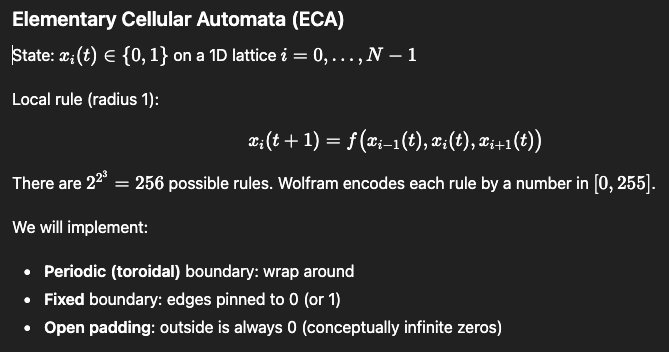

— Rule lookup table

In [ ]:
def wolfram_lut(rule: int) -> np.ndarray:
    """
    Return a lookup table lut[0..7] where index is neighborhood code:
    code = 4*L + 2*C + R, with L,C,R in {0,1}.
    """
    if not (0 <= rule <= 255):
        raise ValueError("rule must be in [0,255]")
    return np.array([(rule >> i) & 1 for i in range(8)], dtype=np.uint8)


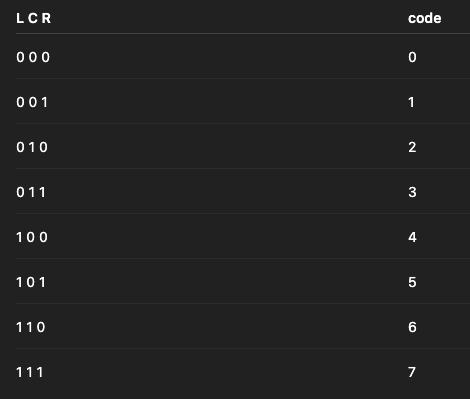

In [ ]:
wolfram_lut(110)

array([0, 1, 1, 1, 0, 1, 1, 0], dtype=uint8)

# Understanding (rule >> i) & 1

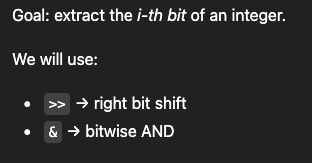

In [ ]:
# Example: Rule 30
rule = 30

print("Rule in decimal:", rule)
print("Rule in binary (8 bits):", format(rule, "08b"))


Rule in decimal: 30
Rule in binary (8 bits): 00011110


— What does >> do?

In [ ]:
rule = 30

for i in range(6):
    shifted = rule >> i
    print(f"i = {i}")
    print("  binary:", format(shifted, "08b"))
    print("  decimal:", shifted)
    print()


i = 0
  binary: 00011110
  decimal: 30

i = 1
  binary: 00001111
  decimal: 15

i = 2
  binary: 00000111
  decimal: 7

i = 3
  binary: 00000011
  decimal: 3

i = 4
  binary: 00000001
  decimal: 1

i = 5
  binary: 00000000
  decimal: 0



— Extracting the last bit with & 1

In [ ]:
rule = 30

for i in range(8):
    shifted = rule >> i
    extracted_bit = shifted & 1

    print(f"i = {i}")
    print("  shifted binary:", format(shifted, "08b"))
    print("  extracted bit :", extracted_bit)
    print()


i = 0
  shifted binary: 00011110
  extracted bit : 0

i = 1
  shifted binary: 00001111
  extracted bit : 1

i = 2
  shifted binary: 00000111
  extracted bit : 1

i = 3
  shifted binary: 00000011
  extracted bit : 1

i = 4
  shifted binary: 00000001
  extracted bit : 1

i = 5
  shifted binary: 00000000
  extracted bit : 0

i = 6
  shifted binary: 00000000
  extracted bit : 0

i = 7
  shifted binary: 00000000
  extracted bit : 0



# CA Dynamics

One step update with boundary options

In [ ]:
def eca_step(x: np.ndarray, lut: np.ndarray, boundary="periodic", fixed_value=0) -> np.ndarray:
    """
    One synchronous update step for ECA.
    boundary: "periodic" | "fixed" | "open"
      - periodic: wrap-around
      - fixed: x[-1] and x[0] see neighbors outside as fixed_value (0 or 1)
      - open: same as fixed with fixed_value=0 (conceptually infinite padding)
    """
    x = x.astype(np.uint8)
    n = x.size

    if boundary == "periodic":
        L = np.roll(x, 1)
        C = x
        R = np.roll(x, -1)

    elif boundary in ("fixed", "open"):
        if boundary == "open":
            fixed_value = 0
        xpad = np.pad(x, (1, 1), mode="constant", constant_values=fixed_value)
        L, C, R = xpad[:-2], xpad[1:-1], xpad[2:]

    else:
        raise ValueError("boundary must be 'periodic', 'fixed', or 'open'")

    code = (L << 2) | (C << 1) | R
    return lut[code]


In [ ]:
rule=27
lut = wolfram_lut(rule)
print(lut)

[1 1 0 1 1 0 0 0]


In [ ]:
seed=42
rng = np.random.default_rng(seed)

n=100

x = (rng.random(n) < 0.5).astype(np.uint8)

print(x)

eca_step(x, lut, boundary="periodic", fixed_value=0)

[0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1
 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1
 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0]


array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1], dtype=uint8)

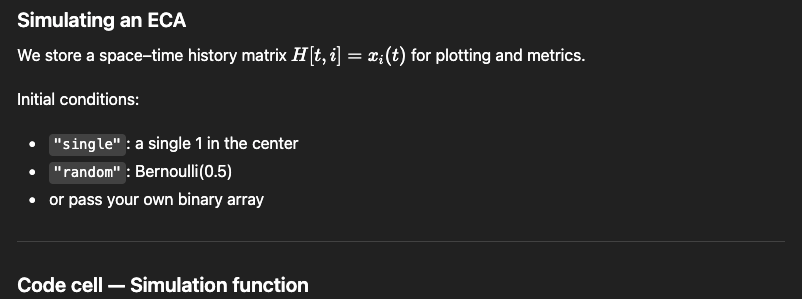

In [ ]:
def eca_run(rule: int, n=200, steps=200, init="single",
            boundary="periodic", fixed_value=0, seed=None) -> np.ndarray:
    """
    Simulate ECA and return history array of shape (steps+1, n).
    """
    rng = np.random.default_rng(seed)
    lut = wolfram_lut(rule)

    if isinstance(init, str):
        x = np.zeros(n, dtype=np.uint8)
        if init == "single":
            x[n//2] = 1
        elif init == "random":
            x = (rng.random(n) < 0.5).astype(np.uint8)
        else:
            raise ValueError("init must be 'single', 'random', or an array")
    else:
        x = np.array(init, dtype=np.uint8)
        if x.size != n:
            raise ValueError("init array must have length n")

    hist = np.zeros((steps+1, n), dtype=np.uint8)
    hist[0] = x

    for t in range(steps):
        x = eca_step(x, lut, boundary=boundary, fixed_value=fixed_value)
        hist[t+1] = x

    return hist


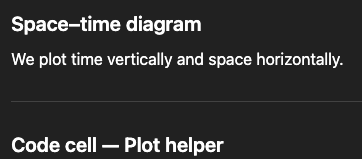

In [ ]:
def plot_spacetime(hist: np.ndarray, title=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(hist, cmap="binary", interpolation="nearest", aspect="auto")
    plt.xlabel("Space i")
    plt.ylabel("Time t")
    if title:
        plt.title(title)
    plt.show()


Example run (Rule 110)

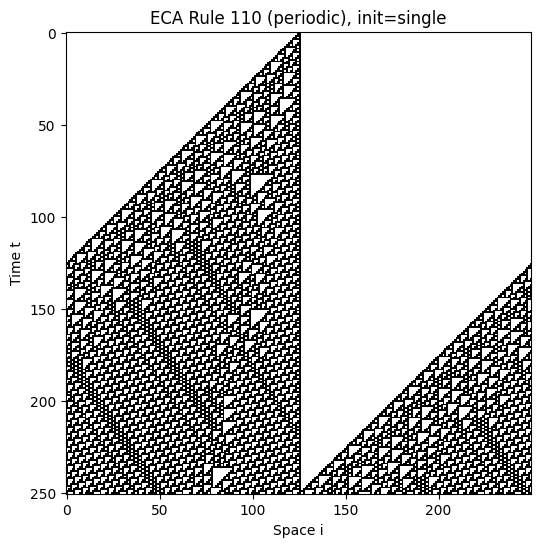

In [ ]:
hist = eca_run(rule=110, n=250, steps=250, init="single", boundary="periodic")
plot_spacetime(hist, title="ECA Rule 110 (periodic), init=single")


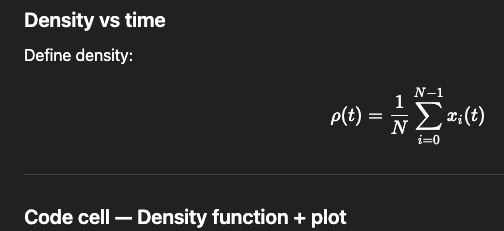

In [ ]:
def density_vs_time(hist: np.ndarray) -> np.ndarray:
    return hist.mean(axis=1)

def plot_density(rho, title=None):
    plt.figure(figsize=(6, 3))
    plt.plot(rho)
    plt.xlabel("Time t")
    plt.ylabel("Density ρ(t)")
    if title:
        plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()




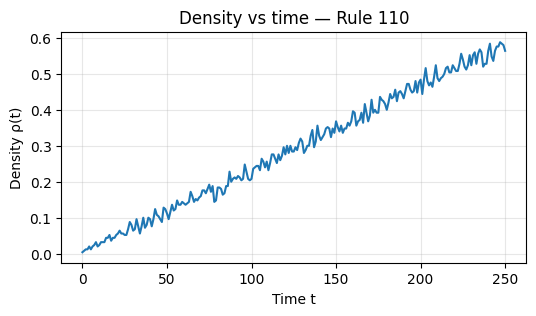

In [ ]:
rho = density_vs_time(hist)
plot_density(rho, title="Density vs time — Rule 110")
#increse time and discuss the asymptotics.....change rules

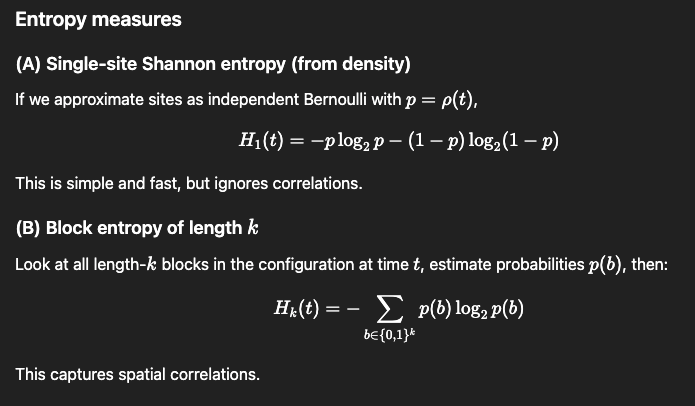

In [ ]:
def shannon_binary(p):
    """Binary Shannon entropy in bits."""
    p = float(p)
    if p <= 0.0 or p >= 1.0:
        return 0.0
    return -(p*np.log2(p) + (1-p)*np.log2(1-p))

def entropy_single_site_from_density(hist: np.ndarray) -> np.ndarray:
    rho = density_vs_time(hist)
    return np.array([shannon_binary(p) for p in rho], dtype=float)

def block_entropy(config: np.ndarray, k=3, boundary="periodic") -> float:
    """
    Block entropy H_k for one configuration (1D binary array).
    boundary controls whether blocks wrap around.
    """
    x = np.array(config, dtype=np.uint8)
    n = x.size
    blocks = []

    if boundary == "periodic":
        # take n blocks, wrapping around
        for i in range(n):
            blk = tuple(x[(i + np.arange(k)) % n])
            blocks.append(blk)
    elif boundary in ("fixed", "open"):
        # take blocks that fully fit inside [0, n-1]
        for i in range(n - k + 1):
            blk = tuple(x[i:i+k])
            blocks.append(blk)
    else:
        raise ValueError("boundary must be periodic/fixed/open")

    counts = Counter(blocks)
    total = sum(counts.values())
    H = 0.0
    for c in counts.values():
        p = c / total
        H -= p * np.log2(p)
    return H

def block_entropy_vs_time(hist: np.ndarray, k=3, boundary="periodic") -> np.ndarray:
    return np.array([block_entropy(hist[t], k=k, boundary=boundary) for t in range(hist.shape[0])], dtype=float)


— Plot entropy vs time

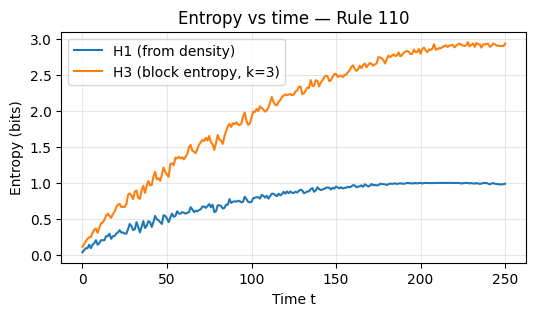

In [ ]:
H1 = entropy_single_site_from_density(hist)
H3 = block_entropy_vs_time(hist, k=3, boundary="periodic")

plt.figure(figsize=(6,3))
plt.plot(H1, label="H1 (from density)")
plt.plot(H3, label="H3 (block entropy, k=3)")
plt.xlabel("Time t")
plt.ylabel("Entropy (bits)")
plt.title("Entropy vs time — Rule 110")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


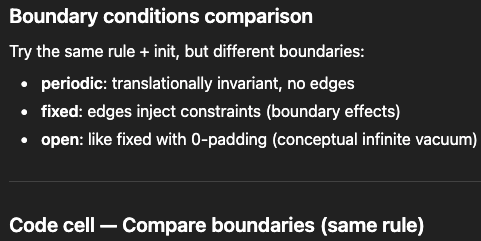

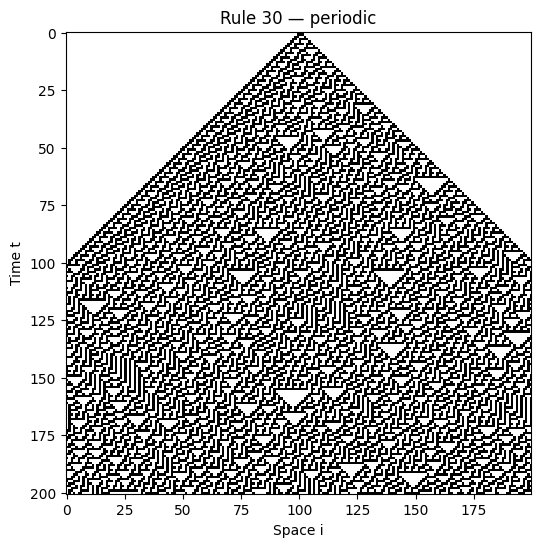

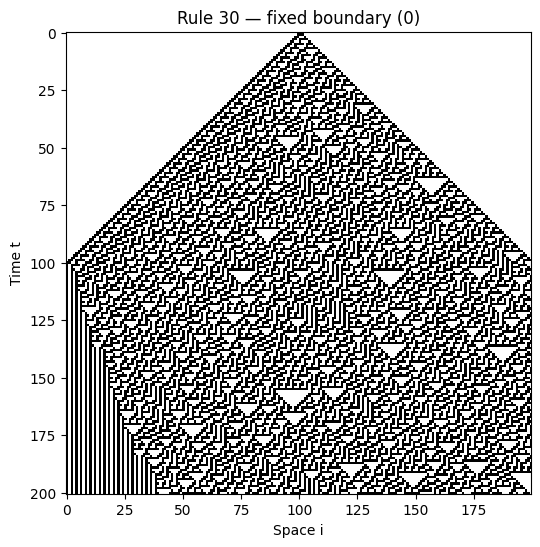

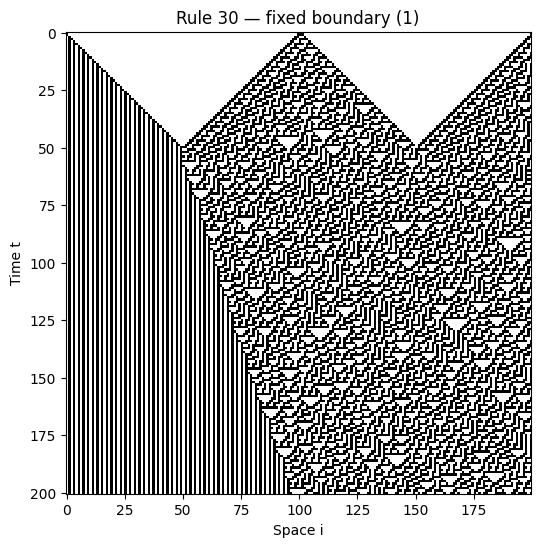

In [ ]:
rule = 30
n, steps = 200, 200

hist_per = eca_run(rule, n=n, steps=steps, init="single", boundary="periodic")
hist_fix0 = eca_run(rule, n=n, steps=steps, init="single", boundary="fixed", fixed_value=0)
hist_fix1 = eca_run(rule, n=n, steps=steps, init="single", boundary="fixed", fixed_value=1)

plot_spacetime(hist_per,  title=f"Rule {rule} — periodic")
plot_spacetime(hist_fix0, title=f"Rule {rule} — fixed boundary (0)")
plot_spacetime(hist_fix1, title=f"Rule {rule} — fixed boundary (1)")


# Wolfram's 4 Classes

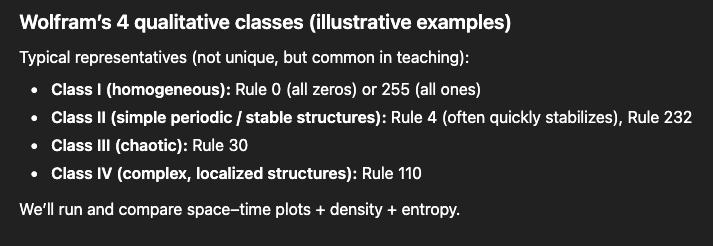

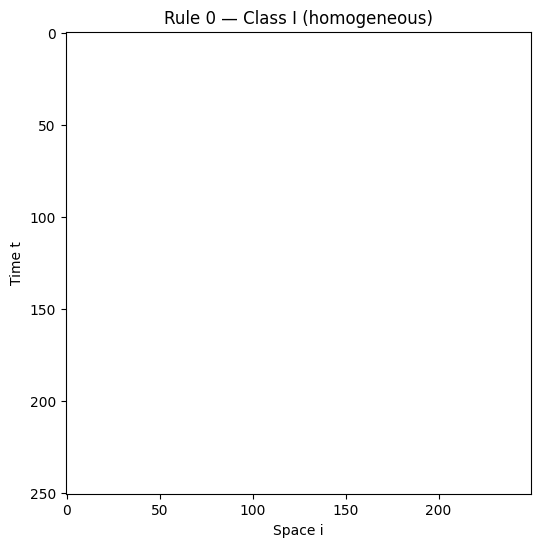

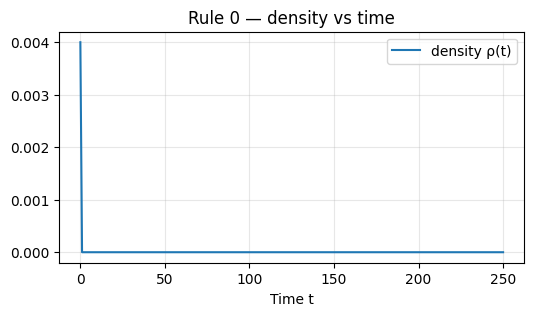

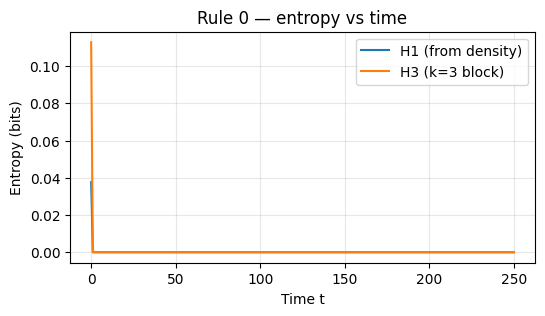

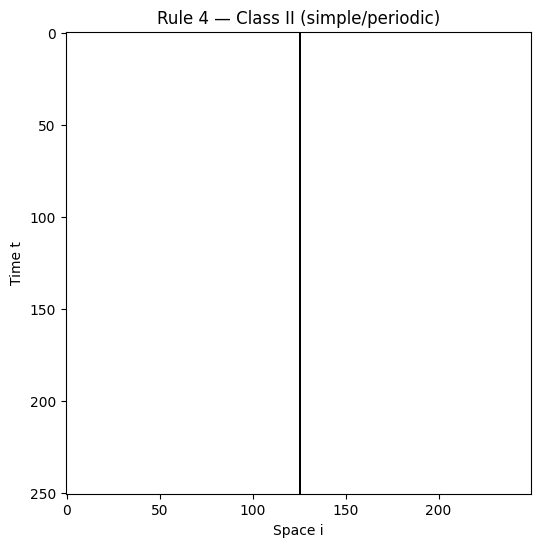

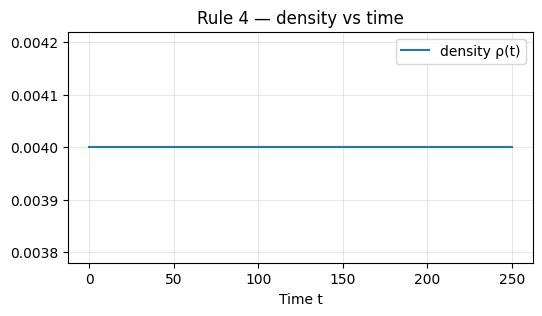

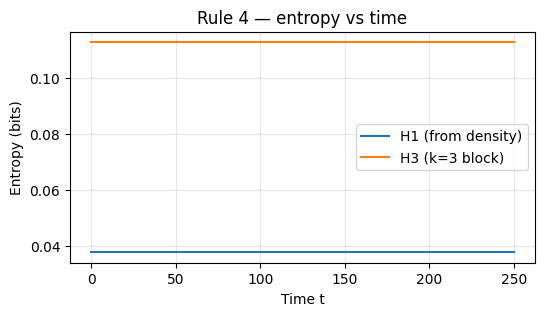

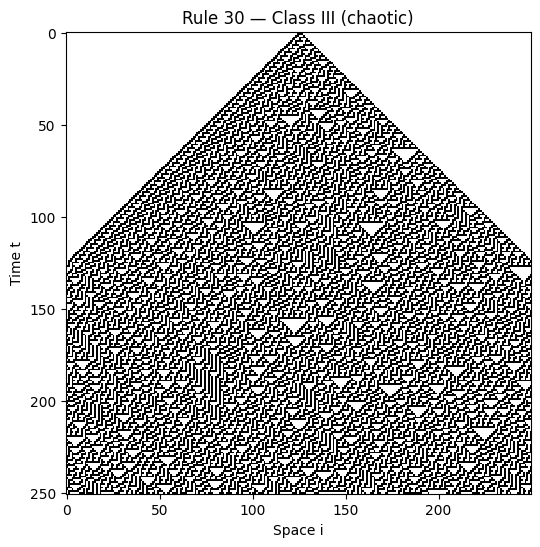

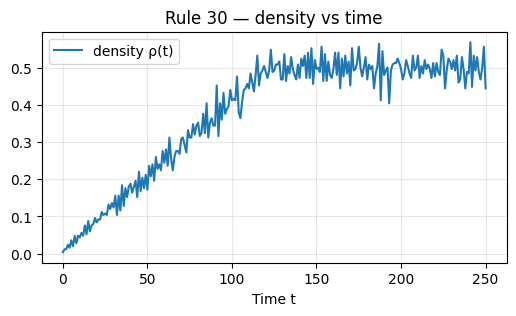

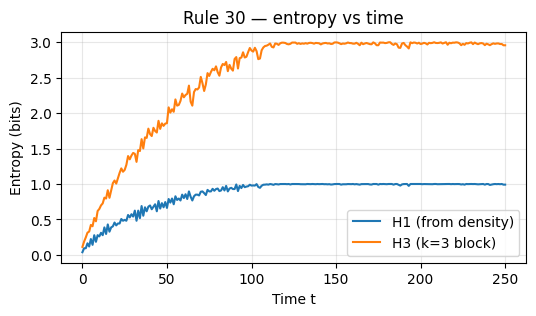

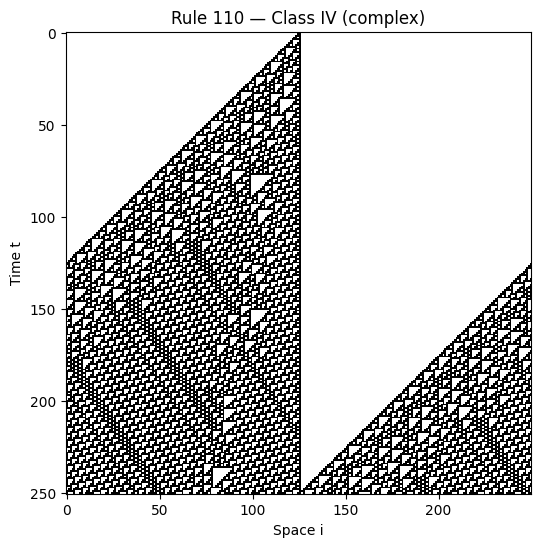

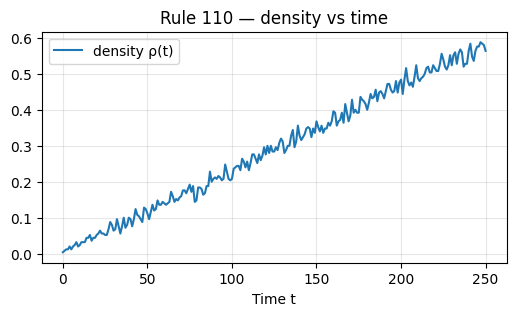

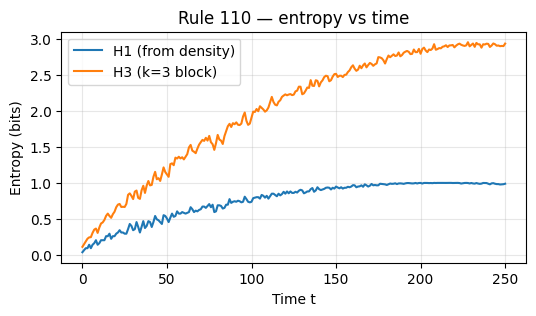

In [ ]:
examples = [
    (0,   "Class I (homogeneous)"),
    (4,   "Class II (simple/periodic)"),
    (30,  "Class III (chaotic)"),
    (110, "Class IV (complex)"),
]

n, steps = 250, 250
init = "single"
boundary = "periodic"

for rule, label in examples:
    hist = eca_run(rule, n=n, steps=steps, init=init, boundary=boundary)
    plot_spacetime(hist, title=f"Rule {rule} — {label}")

    rho = density_vs_time(hist)
    H1 = entropy_single_site_from_density(hist)
    H3 = block_entropy_vs_time(hist, k=3, boundary=boundary)

    plt.figure(figsize=(6,3))
    plt.plot(rho, label="density ρ(t)")
    plt.xlabel("Time t")
    plt.title(f"Rule {rule} — density vs time")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(H1, label="H1 (from density)")
    plt.plot(H3, label="H3 (k=3 block)")
    plt.xlabel("Time t")
    plt.ylabel("Entropy (bits)")
    plt.title(f"Rule {rule} — entropy vs time")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# Conclusions


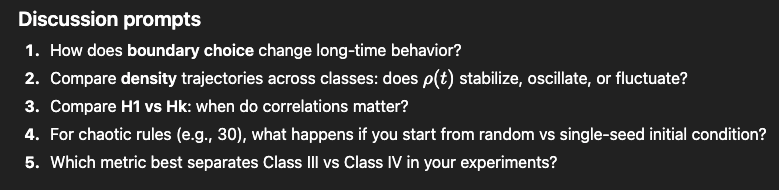

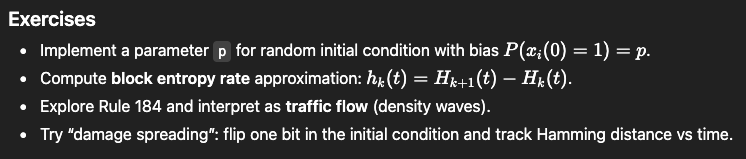